In [1]:
import os

import geopandas as gpd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr, when

from sedona.register import SedonaRegistrator
from sedona.utils import SedonaKryoRegistrator, KryoSerializer
from sedona.core.formatMapper.shapefileParser import ShapefileReader
from sedona.utils.adapter import Adapter
from sedona.core.enums import GridType
from sedona.core.enums import IndexType
from sedona.core.spatialOperator import JoinQueryRaw

## Setup Sedona environment

In [2]:
spark = SparkSession.builder.\
        master("local[*]").\
        appName("SedonaSQL-Example").\
        config("spark.serializer", KryoSerializer.getName).\
        config("spark.kryo.registrator", SedonaKryoRegistrator.getName) .\
        config('spark.jars.packages',
               'org.apache.sedona:sedona-python-adapter-3.0_2.12:1.0.0-incubating,'
               'org.datasyslab:geotools-wrapper:geotools-24.0'). \
        getOrCreate()
SedonaRegistrator.registerAll(spark)
sc = spark.sparkContext
sc.setSystemProperty("sedona.global.charset", "utf8")

## Read countries shapefile into a Sedona DataFrame 
Data link: https://www.naturalearthdata.com/downloads/50m-cultural-vectors/

In [3]:
countries = ShapefileReader.readToGeometryRDD(sc, "data/ne_50m_admin_0_countries_lakes/")
countries_df = Adapter.toDf(countries, spark)
countries_df.createOrReplaceTempView("country")
countries_df.printSchema()

root
 |-- geometry: geometry (nullable = true)
 |-- featurecla: string (nullable = true)
 |-- scalerank: string (nullable = true)
 |-- LABELRANK: string (nullable = true)
 |-- SOVEREIGNT: string (nullable = true)
 |-- SOV_A3: string (nullable = true)
 |-- ADM0_DIF: string (nullable = true)
 |-- LEVEL: string (nullable = true)
 |-- TYPE: string (nullable = true)
 |-- ADMIN: string (nullable = true)
 |-- ADM0_A3: string (nullable = true)
 |-- GEOU_DIF: string (nullable = true)
 |-- GEOUNIT: string (nullable = true)
 |-- GU_A3: string (nullable = true)
 |-- SU_DIF: string (nullable = true)
 |-- SUBUNIT: string (nullable = true)
 |-- SU_A3: string (nullable = true)
 |-- BRK_DIFF: string (nullable = true)
 |-- NAME: string (nullable = true)
 |-- NAME_LONG: string (nullable = true)
 |-- BRK_A3: string (nullable = true)
 |-- BRK_NAME: string (nullable = true)
 |-- BRK_GROUP: string (nullable = true)
 |-- ABBREV: string (nullable = true)
 |-- POSTAL: string (nullable = true)
 |-- FORMAL_EN: st

## Read airports shapefile into a Sedona DataFrame 
Data link: https://www.naturalearthdata.com/downloads/50m-cultural-vectors/

In [4]:
airports = ShapefileReader.readToGeometryRDD(sc, "data/ne_50m_airports/")
airports_df = Adapter.toDf(airports, spark)
airports_df.createOrReplaceTempView("airport")
airports_df.printSchema()

root
 |-- geometry: geometry (nullable = true)
 |-- scalerank: string (nullable = true)
 |-- featurecla: string (nullable = true)
 |-- type: string (nullable = true)
 |-- name: string (nullable = true)
 |-- abbrev: string (nullable = true)
 |-- location: string (nullable = true)
 |-- gps_code: string (nullable = true)
 |-- iata_code: string (nullable = true)
 |-- wikipedia: string (nullable = true)
 |-- natlscale: string (nullable = true)



## Run Spatial Join using SQL API

In [5]:
result = spark.sql("SELECT c.geometry as country_geom, c.NAME_EN, a.geometry as airport_geom, a.name FROM country c, airport a WHERE ST_Contains(c.geometry, a.geometry)")

## Run Spatial Join using RDD API

In [6]:
airports_rdd = Adapter.toSpatialRdd(airports_df, "geometry")
# Drop the duplicate name column in countries_df
countries_df = countries_df.drop("NAME")
countries_rdd = Adapter.toSpatialRdd(countries_df, "geometry")

airports_rdd.analyze()
countries_rdd.analyze()

# 4 is the num partitions used in spatial partitioning. This is an optional parameter
airports_rdd.spatialPartitioning(GridType.KDBTREE, 4)
countries_rdd.spatialPartitioning(airports_rdd.getPartitioner())

buildOnSpatialPartitionedRDD = True
usingIndex = True
considerBoundaryIntersection = True
airports_rdd.buildIndex(IndexType.QUADTREE, buildOnSpatialPartitionedRDD)

result_pair_rdd = JoinQueryRaw.SpatialJoinQueryFlat(airports_rdd, countries_rdd, usingIndex, considerBoundaryIntersection)

result2 = Adapter.toDf(result_pair_rdd, countries_rdd.fieldNames, airports.fieldNames, spark)

result2.createOrReplaceTempView("join_result_with_all_cols")
# Select the columns needed in the join
result2 = spark.sql("SELECT leftgeometry as country_geom, NAME_EN, rightgeometry as airport_geom, name FROM join_result_with_all_cols")

## Print spatial join results

In [7]:
# The result of SQL API
result.show()
# The result of RDD API
result2.show()

+--------------------+--------------------+--------------------+--------------------+
|        country_geom|             NAME_EN|        airport_geom|                name|
+--------------------+--------------------+--------------------+--------------------+
|MULTIPOLYGON (((3...|Zimbabwe         ...|POINT (31.1014 -1...|Harare Int'l     ...|
|MULTIPOLYGON (((3...|Zimbabwe         ...|POINT (28.6225520...|Bulawayo         ...|
|MULTIPOLYGON (((3...|Zambia           ...|POINT (28.4455443...|Lusaka Int'l     ...|
|MULTIPOLYGON (((5...|Yemen            ...|POINT (45.030602 ...|Aden Int'l       ...|
|MULTIPOLYGON (((5...|Yemen            ...|POINT (44.2246467...|Sanaa Int'l      ...|
|MULTIPOLYGON (((1...|Vietnam          ...|POINT (105.803759...|Noi Bai          ...|
|MULTIPOLYGON (((1...|Vietnam          ...|POINT (106.664246...|Tan Son Nhat     ...|
|MULTIPOLYGON (((-...|Venezuela        ...|POINT (-67.005748...|Simon Bolivar Int...|
|MULTIPOLYGON (((-...|Venezuela        ...|POINT (-71.

## Group airports by country

In [8]:
# result.createOrReplaceTempView("result")
result2.createOrReplaceTempView("result")
groupedresult = spark.sql("SELECT c.NAME_EN, c.country_geom, count(*) as AirportCount FROM result c GROUP BY c.NAME_EN, c.country_geom")
groupedresult.show()

+--------------------+--------------------+------------+
|             NAME_EN|        country_geom|AirportCount|
+--------------------+--------------------+------------+
|Peru             ...|POLYGON ((-69.965...|           1|
|Honduras         ...|MULTIPOLYGON (((-...|           1|
|Mali             ...|POLYGON ((-11.389...|           1|
|Bermuda          ...|POLYGON ((-64.730...|           1|
|Ireland          ...|MULTIPOLYGON (((-...|           1|
|Democratic Republ...|POLYGON ((30.7511...|           2|
|Bangladesh       ...|MULTIPOLYGON (((8...|           1|
|Serbia           ...|POLYGON ((21.3600...|           1|
|Croatia          ...|MULTIPOLYGON (((1...|           1|
|Kenya            ...|MULTIPOLYGON (((4...|           2|
|Malta            ...|MULTIPOLYGON (((1...|           1|
|United Arab Emira...|MULTIPOLYGON (((5...|           1|
|Brazil           ...|MULTIPOLYGON (((-...|          12|
|Israel           ...|POLYGON ((35.8691...|           1|
|Lithuania        ...|MULTIPOLY

## Visualize the number of airports in each country

<AxesSubplot:>

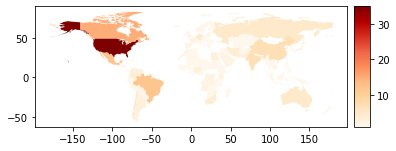

In [9]:
df = groupedresult.toPandas()
gdf = gpd.GeoDataFrame(df, geometry="country_geom")

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(1, 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

gdf.plot(
    column="AirportCount",
    legend=True,
    cmap='OrRd',
    cax=cax,
    ax=ax
)